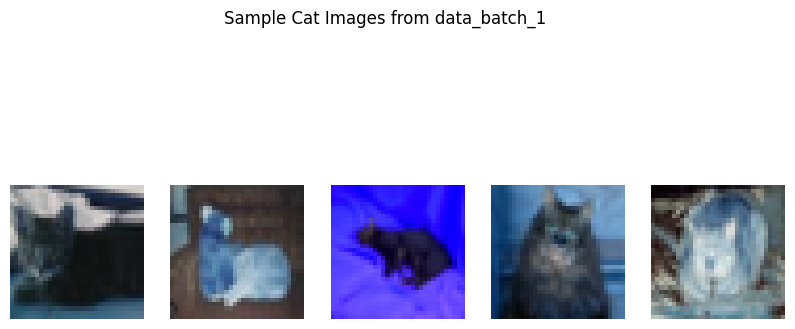

Total Cat Images Extracted: 1016
Model Training Complete. Accuracy: 1.0000
Predicted Class: cat


In [1]:
import pickle
import os
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

dataset_path = r"C:\Users\yuval\Downloads\cifar-10-python\cifar-10-batches-py"
batch_file = os.path.join(dataset_path, "data_batch_1")
meta_file = os.path.join(dataset_path, "batches.meta")

with open(meta_file, 'rb') as f:
    class_names = pickle.load(f, encoding='bytes')[b'label_names']
    class_names = [name.decode('utf-8') for name in class_names]

with open(batch_file, 'rb') as f:
    batch = pickle.load(f, encoding='bytes')

images = batch[b'data']  
labels = batch[b'labels']  

images = images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

cat_index = class_names.index("cat")

cat_images = [img for img, label in zip(images, labels) if label == cat_index]
cat_labels = [label for label in labels if label == cat_index]

cat_images = np.array(cat_images)
cat_labels = np.array(cat_labels)

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(cat_images[i], cv2.COLOR_RGB2BGR))
    plt.axis('off')
plt.suptitle("Sample Cat Images from data_batch_1")
plt.show()

print(f"Total Cat Images Extracted: {len(cat_images)}")

X, y = [], []
for i, img in enumerate(cat_images):
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    gray_img = cv2.resize(gray_img, (128, 128))  # Resize for feature extraction

    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray_img, None)
    sift_feat = np.mean(descriptors, axis=0) if descriptors is not None else np.zeros((128,))
    
    hog_feat, _ = hog(gray_img, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                      orientations=9, visualize=True)
    
    gloh_feat = np.var(descriptors, axis=0) if descriptors is not None else np.zeros((128,))

    features = np.hstack((sift_feat, hog_feat, gloh_feat))
    X.append(features)
    y.append(cat_labels[i])

X = np.array(X)
y = np.array(y)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = rf(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Training Complete. Accuracy: {accuracy:.4f}")

def classify_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.resize(image, (128, 128))

    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    sift_feat = np.mean(descriptors, axis=0) if descriptors is not None else np.zeros((128,))

    hog_feat, _ = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                      orientations=9, visualize=True)

    gloh_feat = np.var(descriptors, axis=0) if descriptors is not None else np.zeros((128,))

    features = np.hstack((sift_feat, hog_feat, gloh_feat)).reshape(1, -1)
    features = scaler.transform(features)

    pred_label = clf.predict(features)[0]
    predicted_class = class_names[pred_label]

    print(f"Predicted Class: {predicted_class}")

test_image_path = r"C:\Users\yuval\OneDrive\Pictures\cat.jpg"
classify_image(test_image_path)
